## Denoising AutoEncoder for Seismic Data Denoising

#### Jun Ji

### Abstract

탄성파 자료처리과정에서 항상 필요한 무작위 잡음을 제거하는 방법으로 딥 신경망 오토인코더(autoencoder) 의 활용 방법을 고찰해 보았다. 오토인코더는 인코더(encoder)와 디코더(decoder)라고 부르는 두 개의 네트워크와 그 사이의 은닉층이 입력층과 출력층에 비하여 다소 작은 크기의 보틀넥(bottleneck) 형태를 갖는 신경망으로, 인코더와 디코더를 어떻게 구성하는냐에 따라서 다양한 형태로 구현이 가능하다. 본 논문에서는 오토인코더를 사용한 잡음제거 원리와 탄성파 자료에서의 잡음에서 방법으로서 사용될 경우에 대한 학습 방법을 설명한다. 그리고, 다양한 구현 방법으로서 완전연결(fully-connected) 신경망, 콘벌루션 신경망, U-Net 형태의 신경망, 그리고 LSTM 을 사용한 RNN구조 등 4 가지의 구조로 오토인코더를 사용하여 잡음제거에서의 활용성을 성능을 비교해 보았다.



* Read Marmousi2D data

In [1]:
import segyio
# !wget 
segy_file = './../Seismic Denoising/marmousi2d/data.segy'
f = segyio.open(segy_file, ignore_geometry=True)

* Segy to numpy array 
* From traces to Common Shot Gather ==> Common Offset Gather
* Crop to fit for patching module with patch_size=40, step_size=20

In [2]:
import numpy as np
CSG = f.trace.raw[:]
CSG.resize(240, 96, 750)
CSG = CSG[:,:,:724]
COG = np.transpose(CSG, (2,1,0))
patch_size = 40
step_size = 20
SIZE_X = (COG.shape[2]//step_size)*step_size
SIZE_Y = (COG.shape[0]//step_size)*step_size
COG_crop = COG[:SIZE_Y,:,:SIZE_X]
print(COG.shape, COG_crop.shape)

(724, 96, 240) (720, 96, 240)


* AGC code and applying to traces

In [3]:
# import numpy as np
# import math
from scipy.signal.windows import triang
from scipy.signal import convolve2d as conv2

def gain(data, dt, option1, parameters, option2):
    '''
    GAIN: Gain a group of traces.
    
      gain(d,dt,option1,parameters,option2);
    
      IN   d(nt,nx):   traces
           dt:         sampling interval
           option1 = 'time' parameters = [a,b],  gain = t.^a . * exp(-bt)
                   = 'agc' parameters = [agc_gate], length of the agc gate in secs
           option2 = 0  No normalization
                   = 1  Normalize each trace by amplitude
                   = 2  Normalize each trace by rms value
    
      OUT  dout(nt,nx): traces after application of gain function
    '''
    nt,nx = data.shape

    dout = np.zeros(data.shape)
    if option1 == 'time':
        a = parameters[0]
        b = parameters[1]
        t = [x*dt for x in range(nt)]
        tgain = [(x**a)*math.exp(x*b) for x in t]

        for k in range(nx):
            dout[:,k] = data[:,k]*tgain

    elif option1 == 'agc':
        L = parameters/dt+1
        L = np.floor(L/2)
        h = triang(2*L+1)
        shaped_h  = h.reshape(len(h),1)

        for k in range(nx):
            aux = data[:,k]
            e = aux**2
            shaped_e = e.reshape(len(e),1)
            
            rms = np.sqrt(conv2(shaped_e,shaped_h,"same"))
            epsi = 1e-10*max(rms)
            op = rms/(rms**2+epsi)
            op = op.reshape(len(op),)

            dout[:,k] = data[:,k]*op

    #Normalize by amplitude 
    if option2==1:
        for k in range(nx):
            aux =  dout[:,k]
            amax = max(abs(aux))
            dout[:,k] = dout[:,k]/amax 

    #Normalize by rms 
    if option2==2:
        for k in range(nx):
            aux = dout[:,k]
            amax = np.sqrt(sum(aux**2)/nt)
            dout[:,k] = dout[:,k]/amax

    return dout

In [4]:
COG_GAIN = gain(COG_crop.reshape(COG_crop.shape[0],-1), dt=0.004, option1='agc', parameters=0.3, option2=1)

* Ploting a nearest offset section after AGC

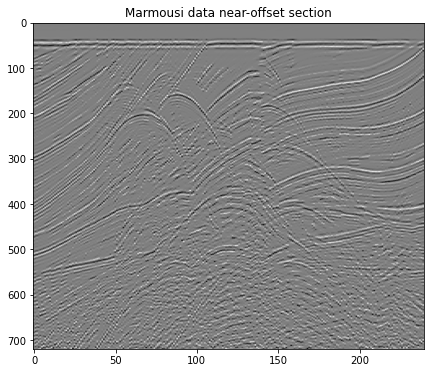

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,6))
plt.imshow(COG_GAIN[:,-240:], cmap='gray', aspect="auto")
plt.title('Marmousi data near-offset section')
plt.savefig('Marmousi_COG.png')

* Code for Adding noises
* Code for Displaying several patches of data
* Code for PNSR

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import time
from keras import backend as K

def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

def noise(array, factor=0.2):
    # Add normally distributed random noises
    noisy_array = array + factor * np.random.normal(0.,1., size=array.shape)
    return np.clip(noisy_array, -1., 1.)

def display(array1, array2, title1="in", title2="out"):
    n = 4
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    patch_size = 60
    
    plt.figure(figsize=(20,8))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image1.reshape(patch_size,patch_size))
        plt.title(title1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2,n,i+1+n)
        plt.imshow(image2.reshape(patch_size,patch_size))
        plt.title(title2)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()  
    
def displayP(array1, array2, name="Data.png"):
    n = 4
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    patch_size = 40
    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(20, 8))

    for i, (image1, image2) in enumerate(zip(images1, images2)):
        axes[0,i].imshow(image1.reshape(patch_size,patch_size), cmap='gray')
        axes[0,i].axis('off')
        axes[1,i].imshow(image2.reshape(patch_size,patch_size), cmap='gray')
        axes[1,i].axis('off')
      
    plt.show() 
    fig.savefig(name)

def tf_log10(x):
    numerator = np.log(x)
    denominator = np.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator


def PSNR(y_true, y_pred):
    max_pixel = np.max(np.abs(y_true)) + 1e-8
    max_pizel = 1.
    y_pred = K.clip(y_pred, 0.0, 1.0)
    return 10.0 * tf_log10((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true))))

def PSNRG(y_true, y_pred):
    m = len(y_true)
    total = np.zeros(m)
    for i in range(m):
        total[i] = PSNR(y_true[i], y_pred[i])
    return np.mean(total), np.var(total)

* Obtain patches from COG ==> COG_ptchs
* Add noises ==> COG_NS_ptchs

In [7]:
import patchify as ptch

patch_size = 40
step_size = 20

COG_NS = noise(COG_GAIN, 0.2)
COG_ptchs = ptch.patchify(COG_GAIN, (patch_size, patch_size), step=step_size)
print(COG_ptchs.shape)
COG_NS_ptchs = ptch.patchify(COG_NS, (patch_size, patch_size), step=step_size)
print(COG_NS_ptchs.shape)

Ptchs_orig_shape = COG_ptchs.shape

COG_ptchs = COG_ptchs.reshape(-1,patch_size, patch_size)
COG_NS_ptchs = COG_NS_ptchs.reshape(-1,patch_size, patch_size)
print(COG_ptchs.shape, COG_NS_ptchs.shape)
displayP(COG_ptchs[14200:14400], COG_NS_ptchs[14200:14400], name="Original_ptchs.png")

(35, 1151, 40, 40)
(35, 1151, 40, 40)
(40285, 40, 40) (40285, 40, 40)


## Fully-connected Autoencoder (FAE)

* Autoencoder using Fully-connected layers 

In [8]:
COG_ptchs_fc    = COG_ptchs.reshape((len(COG_ptchs), np.prod(COG_ptchs.shape[1:])))
COG_NS_ptchs_fc = COG_NS_ptchs.reshape((len(COG_ptchs), np.prod(COG_ptchs.shape[1:])))
print(COG_ptchs_fc.shape, COG_NS_ptchs_fc.shape)

(40285, 1600) (40285, 1600)


In [9]:
from tensorflow.keras.layers import Input, Dense

input_size = patch_size * patch_size

input = Input(shape=(input_size,))
x = Dense(1024, activation="relu")(input)
x = Dense(800, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(800, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(input_size, activation=None)(x)

fae = Model(input, x)
fae.compile(optimizer="adam", loss="mean_squared_error", metrics=['accuracy'])
fae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1600)]            0         
                                                                 
 dense (Dense)               (None, 1024)              1639424   
                                                                 
 dense_1 (Dense)             (None, 800)               820000    
                                                                 
 dense_2 (Dense)             (None, 512)               410112    
                                                                 
 dense_3 (Dense)             (None, 800)               410400    
                                                                 
 dense_4 (Dense)             (None, 1024)              820224    
                                                                 
 dense_5 (Dense)             (None, 1600)              164000

* For train, use all COG patches except patches from last near-offset section [-432:]

In [10]:
start = time.time()
fae_result = fae.fit(
    x=COG_NS_ptchs_fc[:-432],
    y=COG_ptchs_fc[:-432],
    epochs=400,
    batch_size=256,
    shuffle=True,
    validation_split=0.05,
    verbose=0
)
end = time.time()
fae_time = end-start

In [11]:
fae_time_min = fae_time // 60 
fae_time_sec = fae_time % 60 
print(fae_time_min, ":", fae_time_sec)

5.0 : 15.069059371948242


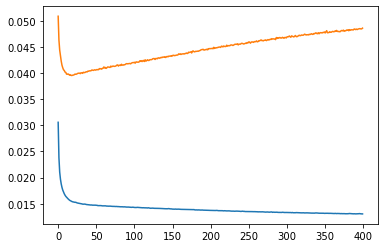

In [12]:
plt.plot(fae_result.history['loss'])
plt.plot(fae_result.history['val_loss'])
plt.show()

(40285, 1600) (40285, 1600)


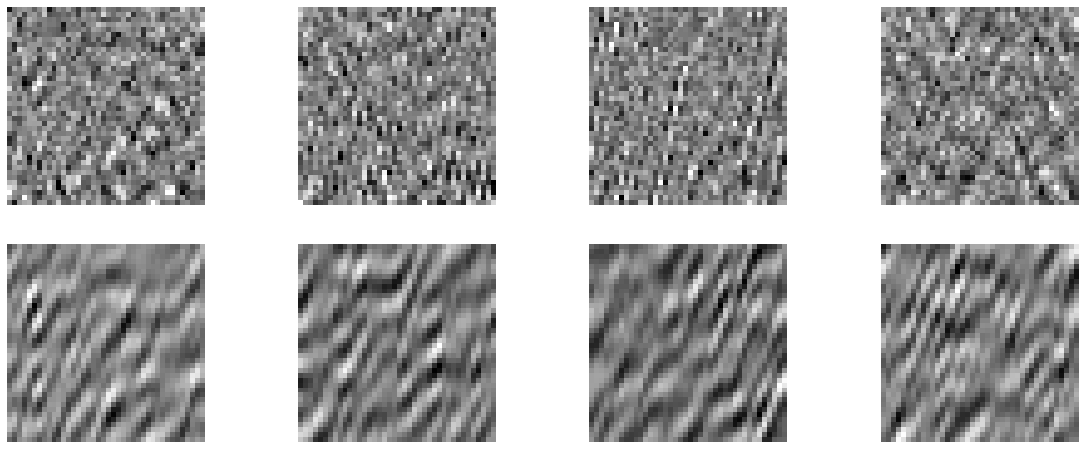

In [13]:
predictions = fae.predict(COG_NS_ptchs_fc)
print(COG_NS_ptchs_fc.shape, predictions.shape)
displayP(COG_NS_ptchs_fc[-250:], predictions[-250:], name="FAE_ptchs.png")

* For test and check performance in PSNR , use patches from the last near-offset section [-432:]

In [14]:
PSNR_fae = PSNR(COG_NS_ptchs_fc[-100], predictions[-100])
print(PSNR_fae)
PSNRG_fae = PSNRG(COG_NS_ptchs_fc[-432:], predictions[-432:])
print(PSNRG_fae)

10.507266521453857
(10.212949871740959, 0.0802761483461809)


In [15]:
predictions.shape, Ptchs_orig_shape, COG_GAIN.shape

((40285, 1600), (35, 1151, 40, 40), (720, 23040))

In [16]:
23*767, 767*40

(17641, 30680)

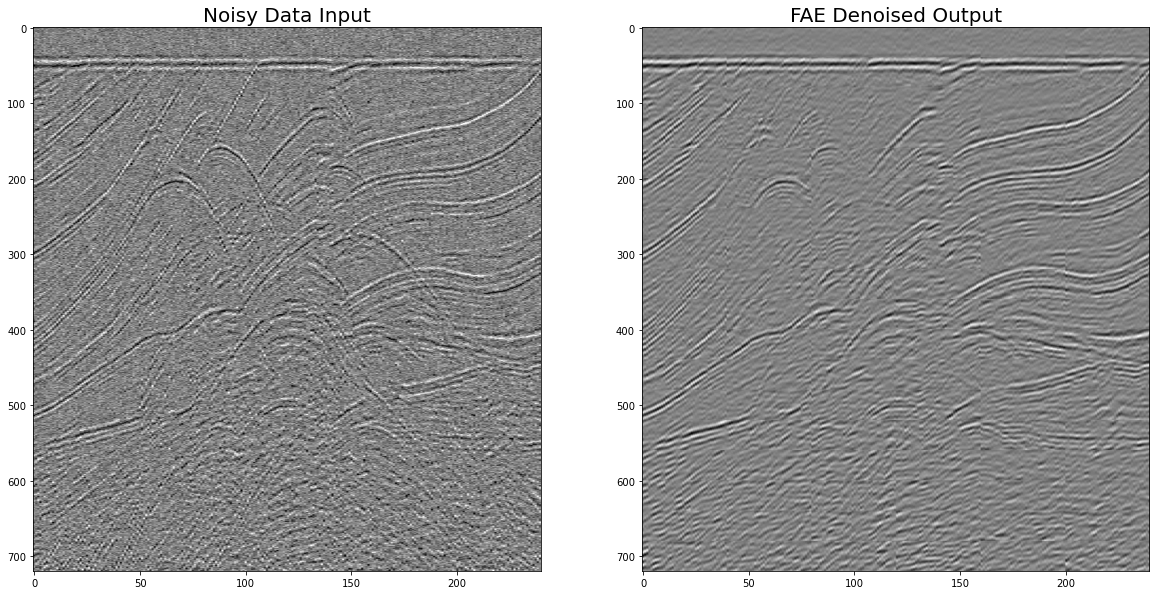

In [17]:
COG_DN = ptch.unpatchify(predictions.reshape(Ptchs_orig_shape), COG_GAIN.shape)
COG_NS = ptch.unpatchify(COG_NS_ptchs.reshape(Ptchs_orig_shape), COG_GAIN.shape)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(COG_NS[:,-240:], cmap='gray', aspect="auto")
plt.title("Noisy Data Input", fontsize=20)
plt.subplot(1,2,2)
plt.imshow(COG_DN[:,-240:], cmap='gray', aspect="auto")
plt.title("FAE Denoised Output", fontsize=20)
plt.savefig('FAE.png')

## Convolutional Auotoencoder (CAE)

* Autoencoder using Convolution layers 

In [18]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose

# When patch_size = 60, the following code works ============
# input = Input(shape=(patch_size,patch_size,1))
# # Encoder
# x = Conv2D(32, (3,3), activation="relu", padding="same")(input)
# x = MaxPooling2D((2,2), padding="same")(x)
# x = Conv2D(64, (3,3), activation="relu", padding="same")(x)
# x = MaxPooling2D((2,2), padding="same")(x)
# x = Conv2D(128, (3,3), activation="relu", padding="valid")(x)
# x = MaxPooling2D((2,2), padding="same")(x)
# # Decoder
# x = Conv2DTranspose(128, (3,3), strides=2, activation="relu", padding="valid")(x)
# x = Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)
# x = Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)
# output = Conv2D(1, (3,3), activation=None, padding="same")(x)
# cae = Model(input,output)
# cae.summary()

In [19]:
input = Input(shape=(patch_size,patch_size,1))
# Encoder
x = Conv2D(32, (3,3), activation="relu", padding="same")(input)
x = MaxPooling2D((2,2), padding="same")(x)
x = Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = MaxPooling2D((2,2), padding="same")(x)
x = Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = MaxPooling2D((2,2), padding="same")(x)
# Decoder
x = Conv2DTranspose(128, (3,3), strides=2, activation="relu", padding="same")(x)
x = Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)
x = Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)
output = Conv2D(1, (3,3), activation=None, padding="same")(x)

cae = Model(input,output)
cae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 40, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 40, 40, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       7385

In [20]:
cae.compile(optimizer="adam", loss="mean_squared_error", metrics=['accuracy'])

In [21]:
start = time.time()

cae_result = cae.fit(
    x=COG_NS_ptchs[:-432],
    y=COG_ptchs[:-432],
    epochs=400,
    batch_size=256,
    shuffle=True,
    validation_split=0.05,
    verbose=0
)

end = time.time()
cae_time = end - start
cae_time_min = cae_time // 60 
cae_time_sec = cae_time % 60 
print(cae_time_min, ":", cae_time_sec)

29.0 : 7.650353670120239


In [22]:
predictions1 = cae.predict(COG_NS_ptchs)
displayP(COG_NS_ptchs, predictions1, name="CAE_ptchs.png")

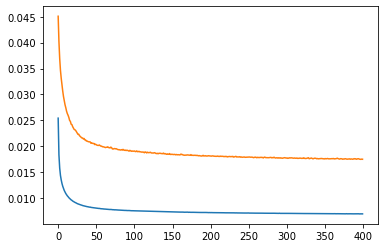

In [23]:
plt.plot(cae_result.history['loss'])
plt.plot(cae_result.history['val_loss'])
plt.show()

In [24]:
PSNR_cae = PSNR(COG_ptchs[-100], predictions1[-100])
print(PSNR_cae)
PSNRG_cae = PSNRG(COG_ptchs[-432:], predictions1[-432:])
print(PSNRG_cae)

11.590224504470825
(10.861950694686836, 0.1892606062166182)


In [25]:
COG_DN = ptch.unpatchify(predictions1.reshape(Ptchs_orig_shape), COG_GAIN.shape)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(COG_NS[:,-240:], cmap='gray', aspect="auto")
plt.title("Original Noisy Data", fontsize=20)
plt.subplot(1,2,2)
plt.imshow(COG_DN[:,-240:], cmap='gray', aspect="auto")
plt.title("CAE Denoised Output", fontsize=20)
plt.savefig('CAE.png')

## U-Net Autoencoder (UAE)

* Autoencoder using UNet-like network 

In [26]:
from tensorflow.keras.layers import concatenate, MaxPooling2D, Conv2DTranspose

# When patch_size = 60, the following code works ============
# input = Input(shape=(patch_size,patch_size,1))
# # Encoder
# c1 = Conv2D(32, (3,3), activation="relu", padding="same")(input)
# c2 = MaxPooling2D((2,2), padding="same")(c1)
# c2 = Conv2D(64, (3,3), activation="relu", padding="same")(c2)
# c3 = MaxPooling2D((2,2), padding="same")(c2)
# c3 = Conv2D(128, (3,3), activation="relu", padding="same")(c3)
# c4 = MaxPooling2D((2,2), padding="valid")(c3)
# # Decoder
# u5 = Conv2DTranspose(128, (3,3), strides=2, activation="relu", padding="valid")(c4)
# u4 = concatenate([u5,c3])
# u3 = Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(u4)
# u2 = concatenate([u3,c2])
# u1 = Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(u2)
# u0 = concatenate([u1,c1])
# output = Conv2D(1, (3,3), activation=None, padding="same")(u0)
# uae = Model(input,output)
# uae.summary()

In [27]:
input = Input(shape=(patch_size,patch_size,1))
# Encoder
c1 = Conv2D(32, (3,3), activation="relu", padding="same")(input)
c2 = MaxPooling2D((2,2), padding="same")(c1)
c2 = Conv2D(64, (3,3), activation="relu", padding="same")(c2)
c3 = MaxPooling2D((2,2), padding="same")(c2)
c3 = Conv2D(128, (3,3), activation="relu", padding="same")(c3)
c4 = MaxPooling2D((2,2), padding="same")(c3)
# Decoder
u5 = Conv2DTranspose(128, (3,3), strides=2, activation="relu", padding="same")(c4)
u4 = concatenate([u5,c3])
u3 = Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(u4)
u2 = concatenate([u3,c2])
u1 = Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(u2)
u0 = concatenate([u1,c1])
output = Conv2D(1, (3,3), activation=None, padding="same")(u0)

uae = Model(input,output)
uae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40, 40, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 40, 40, 32)   320         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 20, 20, 32)  0           ['conv2d_4[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 20, 20, 64)   18496       ['max_pooling2d_3[0][0]']        
                                                                                            

In [28]:
uae.compile(optimizer="adam", loss="MeanSquaredError", metrics=['accuracy'])
start = time.time()

uae_result = uae.fit(
    x=COG_NS_ptchs[:-432],
    y=COG_ptchs[:-432],
    epochs=400,
    batch_size=256,
    shuffle=True,
    validation_split=0.05,
    verbose=0
)
end = time.time()
uae_time = end - start
uae_time_min = uae_time // 60 
uae_time_sec = uae_time % 60 
print(uae_time_min, ":", uae_time_sec)

40.0 : 18.3084614276886


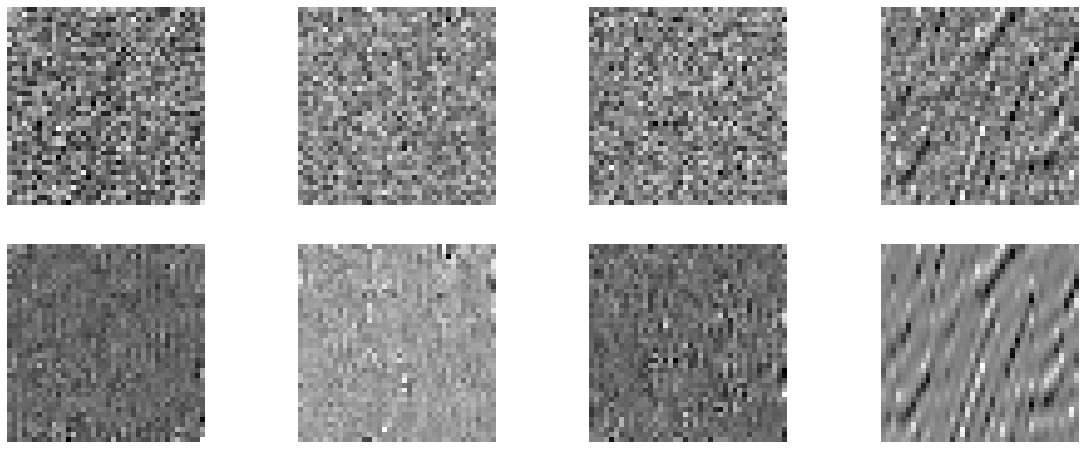

In [29]:
predictions2 = uae.predict(COG_NS_ptchs)
displayP(COG_NS_ptchs, predictions2, name="UAE_ptchs.png")

In [30]:
plt.plot(uae_result.history['loss'])
plt.plot(uae_result.history['val_loss'])
plt.show()

In [31]:
PSNR_uae = PSNR(COG_ptchs[-100], predictions2[-100])
print(PSNR_uae)
PSNRG_uae = PSNRG(COG_ptchs[-432:], predictions2[-432:])
print(PSNRG_uae)

11.387948989868164
(10.645370522031078, 0.18245083790143427)


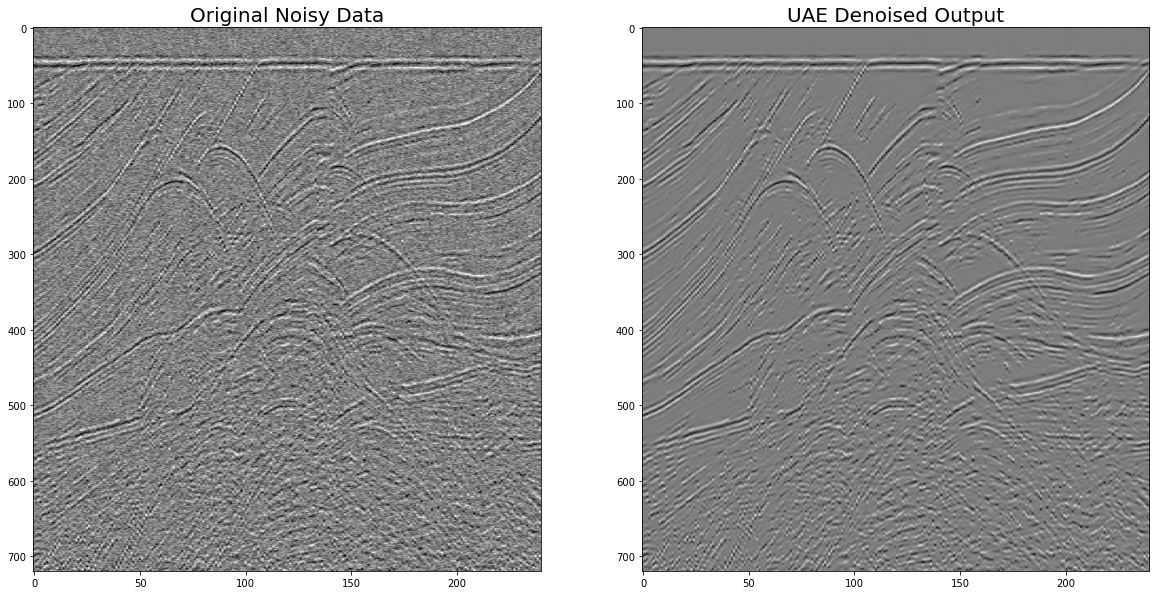

In [32]:
COG_DN = ptch.unpatchify(predictions2.reshape(Ptchs_orig_shape), COG_GAIN.shape)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(COG_NS[:,-240:], cmap='gray', aspect="auto")
plt.title("Original Noisy Data", fontsize=20)
plt.subplot(1,2,2)
plt.imshow(COG_DN[:,-240:], cmap='gray', aspect="auto")
plt.title("UAE Denoised Output", fontsize=20)
plt.savefig('UAE.png')

## LSTM

* Autoencoder using LSTM RNN

In [33]:
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed

n_features = patch_size
time_steps = patch_size

lae = tf.keras.models.Sequential()
lae.add(LSTM(256, input_shape=(time_steps, n_features), return_sequences=True))
lae.add(LSTM(128, return_sequences=False))
lae.add(RepeatVector(time_steps))
lae.add(LSTM(128, return_sequences=True))
lae.add(LSTM(256, return_sequences=True))
lae.add(TimeDistributed(Dense(n_features)))

lae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 256)           304128    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 repeat_vector (RepeatVector  (None, 40, 128)          0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 40, 128)           131584    
                                                                 
 lstm_3 (LSTM)               (None, 40, 256)           394240    
                                                                 
 time_distributed (TimeDistr  (None, 40, 40)           10280     
 ibuted)                                                

In [34]:
(720/20)*(240/20)

432.0

In [35]:
lae.compile(optimizer='adam', loss='MeanSquaredError', metrics=['accuracy'])
start = time.time()

lae_result = lae.fit(    
    x=COG_NS_ptchs[:-432],
    y=COG_ptchs[:-432],
    epochs=400,
    batch_size=256,
    shuffle=True,
    validation_split=0.05,
    verbose=0
)
end = time.time()
lae_time = end - start
lae_time_min = lae_time // 60 
lae_time_sec = lae_time % 60 
print(lae_time_min, ":", lae_time_sec)

25.0 : 32.12831783294678


In [36]:
predictions3 = lae.predict(COG_NS_ptchs)
displayP(COG_NS_ptchs, predictions3, name="LSTM_ptchs.png")

In [37]:
plt.plot(lae_result.history['loss'])
plt.plot(lae_result.history['val_loss'])
plt.show()

In [38]:
PSNR_lstm = PSNR(COG_ptchs[-100], predictions3[-100])
print(PSNR_lstm)
PSNRG_lstm = PSNRG(COG_ptchs[-432:], predictions3[-432:])
print(PSNRG_lstm)

13.161293268203735
(12.364210122161442, 0.22143371064796621)


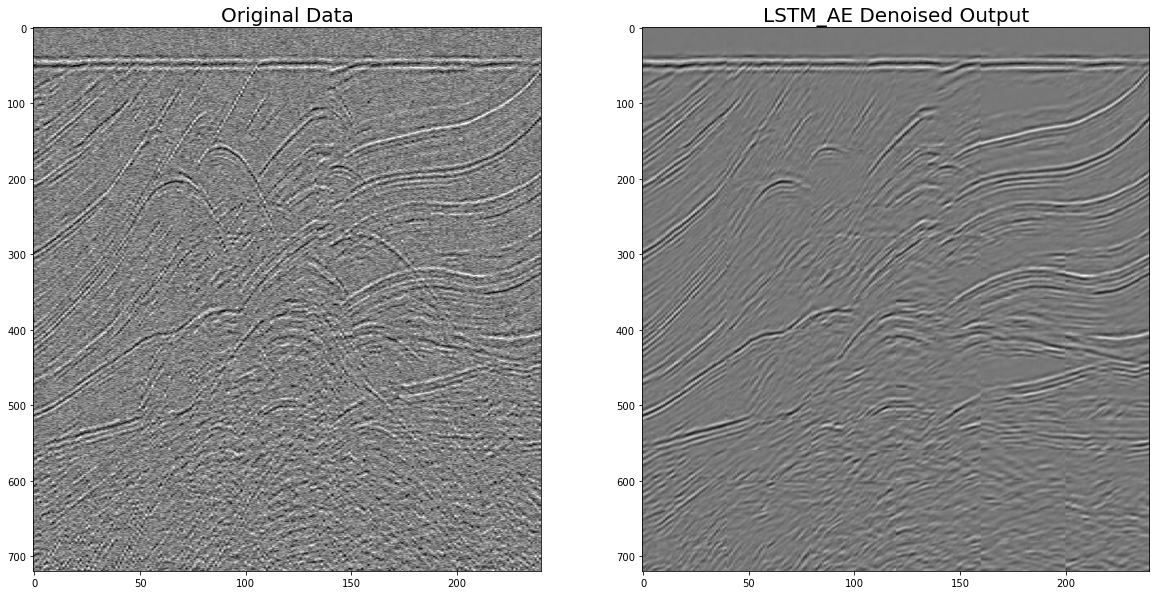

In [39]:
COG_DN = ptch.unpatchify(predictions3.reshape(Ptchs_orig_shape), COG_GAIN.shape)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(COG_NS[:,-240:], cmap='gray', aspect="auto")
plt.title("Original Data", fontsize=20)
plt.subplot(1,2,2)
plt.imshow(COG_DN[:,-240:], cmap='gray', aspect="auto")
plt.title("LSTM_AE Denoised Output", fontsize=20)
plt.savefig('LSTM.png')

## Real data example

In [40]:
import segyio

#!wget http://seismic.physics.ualberta.ca/data/616_79_PR.SGY

segy_file = 'Sample/616_79_PR.SGY'
f0 = segyio.open(segy_file, ignore_geometry=True)
print(len(f0.trace), len(f0.trace[0]))
import numpy as np

COG = f0.trace.raw[:]

def preprocess(array):
    max_value = np.max(np.abs(array))
    array = array / max_value
    return array

COG = preprocess(COG.T)
print(COG.shape)

# Amax = np.max(np.abs(COG))
# COG_clip = np.clip(COG, -Amax*0.80, Amax*0.80)
print(np.max(np.abs(COG)))

1908 1500
(1500, 1908)
1.0


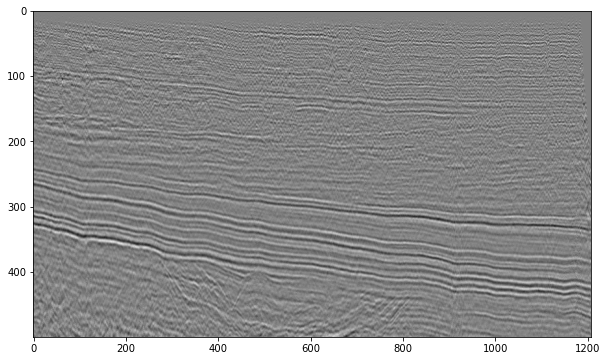

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.imshow(COG[:500, 700:], cmap='gray', aspect='auto')

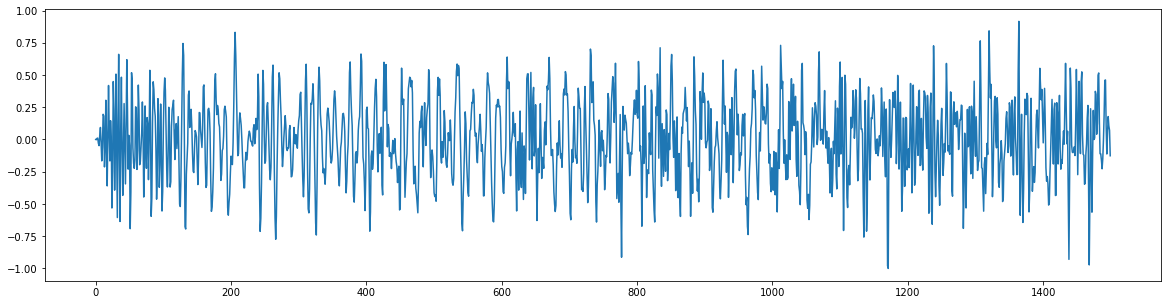

In [42]:
COG_GAIN = gain(COG, dt=0.004, option1='agc', parameters=0.3, option2=1)
plt.figure(figsize=(20,5))
plt.plot(COG_GAIN[:,700])
plt.show()

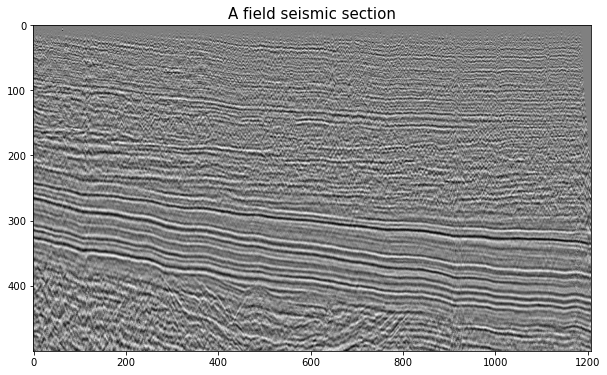

In [43]:
plt.figure(figsize=(10,6))
plt.imshow(COG_GAIN[:500, 700:], cmap='gray', aspect='auto')
plt.title("A field seismic section", fontsize=15)
plt.savefig('Real0.png')

In [44]:
patch_size = 40
step_size = 20
SIZE_Y = (COG.shape[0]//step_size) * step_size
SIZE_X = (COG.shape[1]//step_size) * step_size
COG = COG_GAIN[:SIZE_Y,:SIZE_X]
COG_crop = COG.reshape(COG.shape[0],-1)
print(COG.shape, COG_crop.shape)

(1500, 1900) (1500, 1900)


In [45]:
def displayP(array1, array2, name="Data.png"):
    n = 4
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    width = 40
    height = 40
    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(20, 8))

    for i, (image1, image2) in enumerate(zip(images1, images2)):
        axes[0,i].imshow(image1.reshape(width,height), cmap='gray')
        axes[0,i].axis('off')
        axes[1,i].imshow(image2.reshape(width,height), cmap='gray')
        axes[1,i].axis('off')
      
    plt.show() 
    fig.savefig(name)

(74, 94, 40, 40)
(6956, 40, 40)


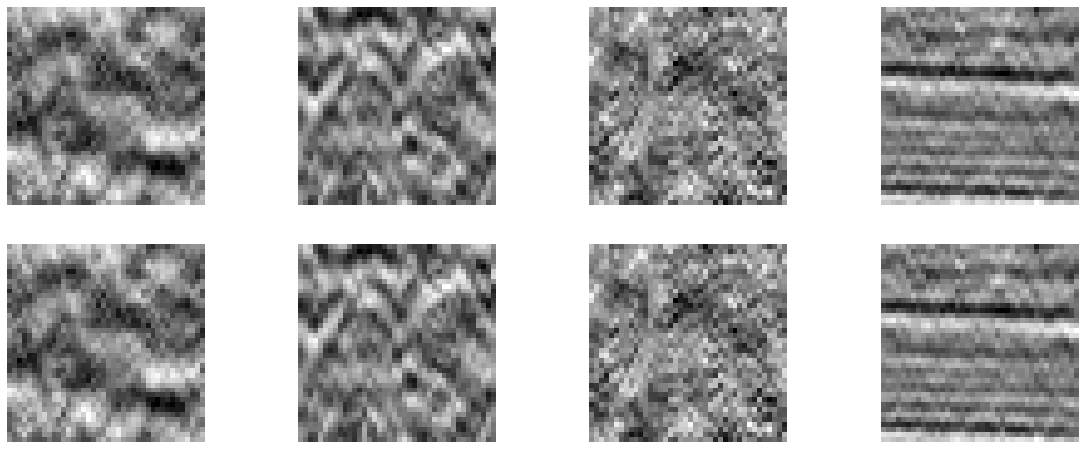

In [46]:
import patchify as ptch

COG_ptchs = ptch.patchify(COG_crop, (patch_size, patch_size), step=step_size)
print(COG_ptchs.shape)

Ptchs_orig_shape = COG_ptchs.shape
COG_ptchs = COG_ptchs.reshape(-1, patch_size, patch_size)
print(COG_ptchs.shape)
displayP(COG_ptchs, COG_ptchs, name='2DLand_patches.png')

In [47]:
COG_ptchs_fc = COG_ptchs.reshape((len(COG_ptchs), np.prod(COG_ptchs.shape[1:])))
print(COG_ptchs_fc.shape)

(6956, 1600)


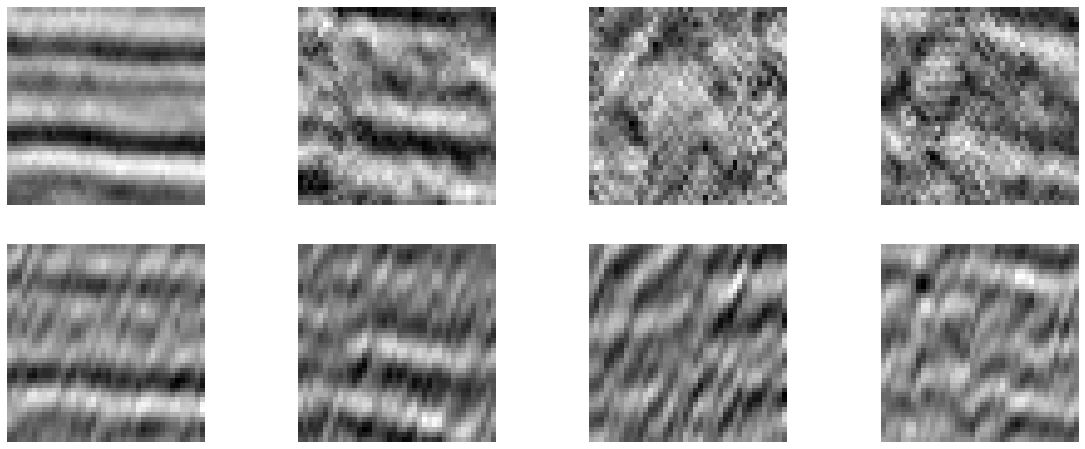

In [48]:
real_fae_predictions = fae.predict(COG_ptchs_fc)
displayP(COG_ptchs_fc, real_fae_predictions, name='2D_simple_fae.png')

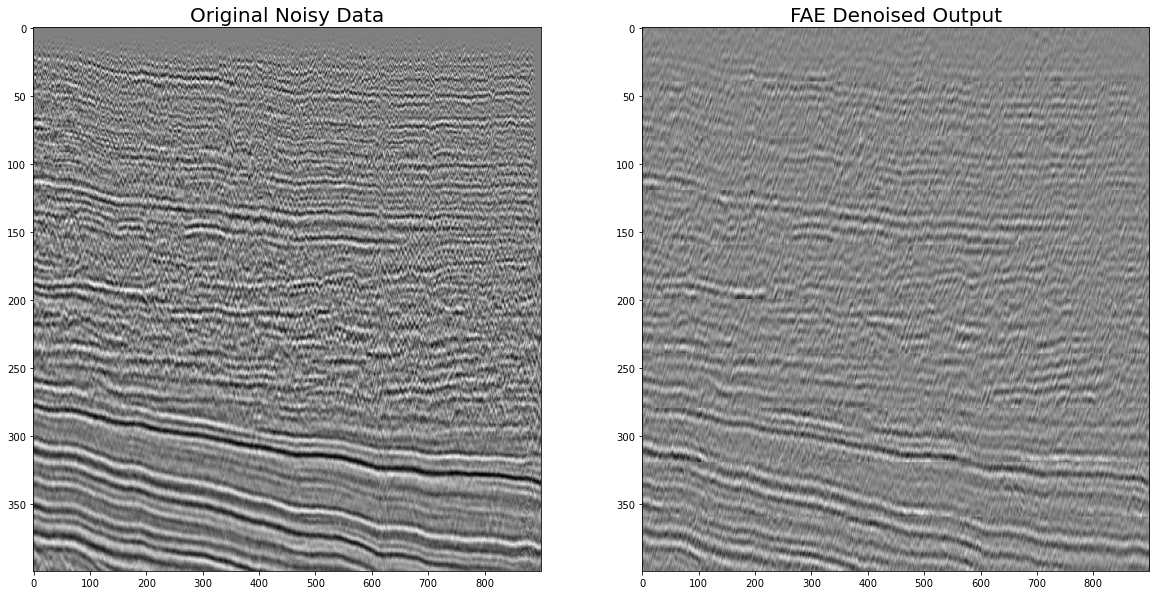

In [49]:
COG_DN0 = ptch.unpatchify(real_fae_predictions.reshape(Ptchs_orig_shape), COG_crop.shape)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(COG_crop[:400, 1000:], cmap='gray', aspect="auto")
plt.title("Original Noisy Data", fontsize=20)
plt.subplot(1,2,2)
plt.imshow(COG_DN0[:400,1000:], cmap='gray', aspect="auto")
plt.title("FAE Denoised Output", fontsize=20)
plt.savefig('Real_FAE.png')

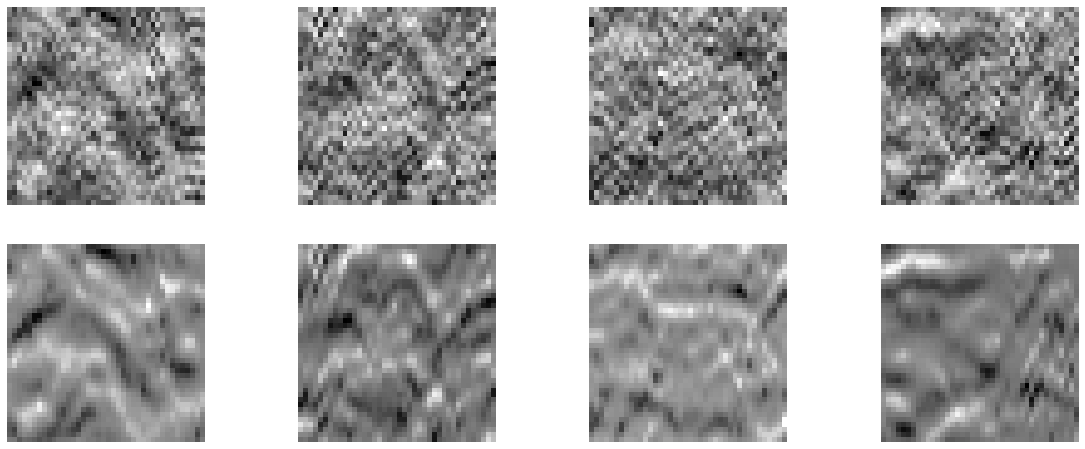

In [50]:
real_cae_predictions = cae.predict(COG_ptchs)
displayP(COG_ptchs, real_cae_predictions, name="2D_simple_cae.png")

In [51]:
COG_DN1 = ptch.unpatchify(real_cae_predictions.reshape(Ptchs_orig_shape), COG_crop.shape)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(COG_crop[:400, 1000:], cmap='gray', aspect="auto")
plt.title("Original Noisy Data", fontsize=20)
plt.subplot(1,2,2)
plt.imshow(COG_DN1[:400,1000:], cmap='gray', aspect="auto")
plt.title("CAE Denoised Output", fontsize=20)
plt.savefig('Real_CAE.png')

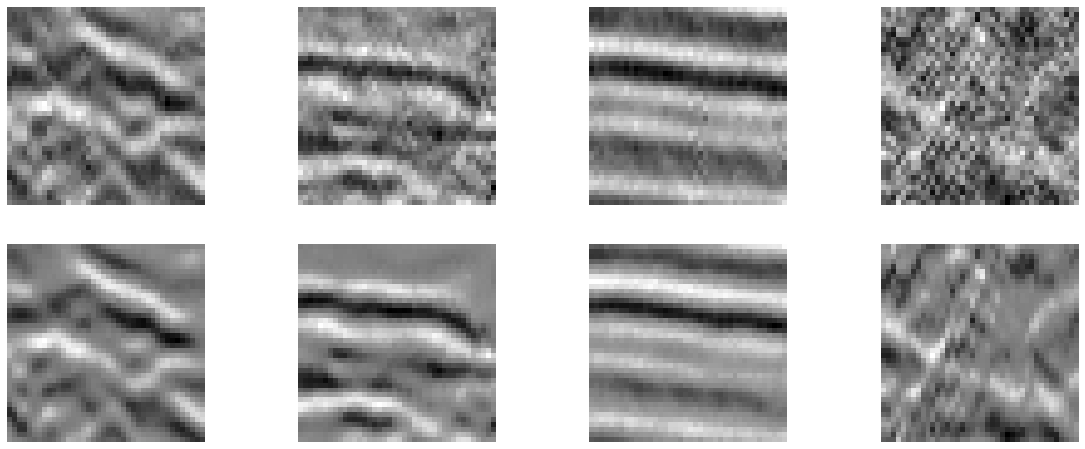

In [52]:
real_uae_predictions = uae.predict(COG_ptchs)
displayP(COG_ptchs, real_uae_predictions, name="2D_simple_uae.png")

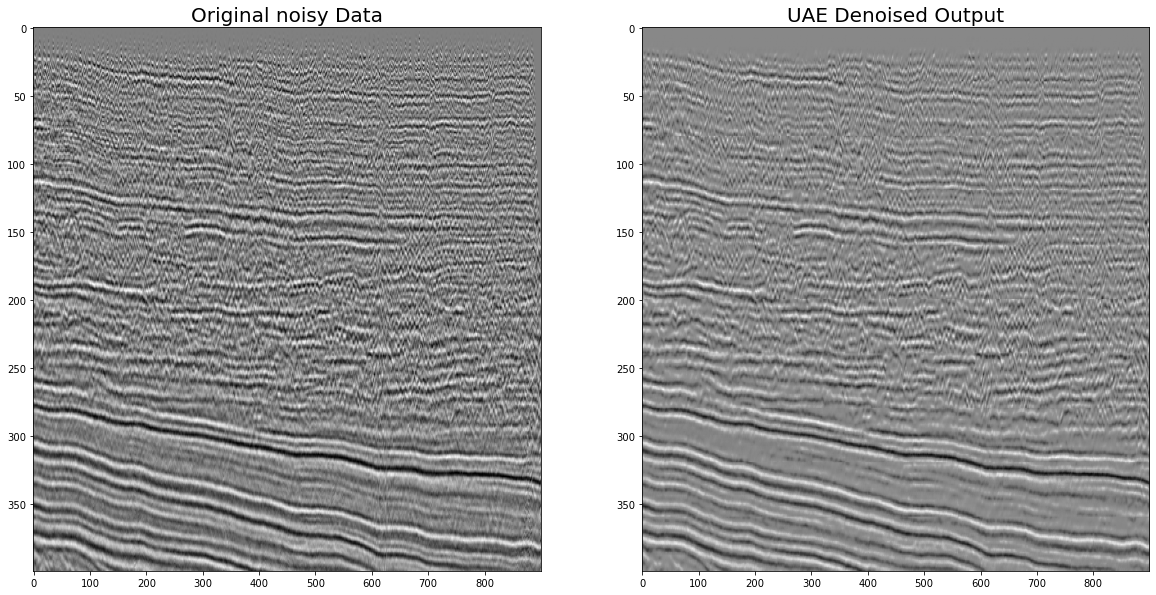

In [53]:
COG_DN2 = ptch.unpatchify(real_uae_predictions.reshape(Ptchs_orig_shape), COG_crop.shape)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(COG_crop[:400, 1000:], cmap='gray', aspect="auto")
plt.title("Original noisy Data", fontsize=20)
plt.subplot(1,2,2)
plt.imshow(COG_DN2[:400, 1000:], cmap='gray', aspect="auto")
plt.title("UAE Denoised Output", fontsize=20)
plt.savefig('Real_UAE.png')

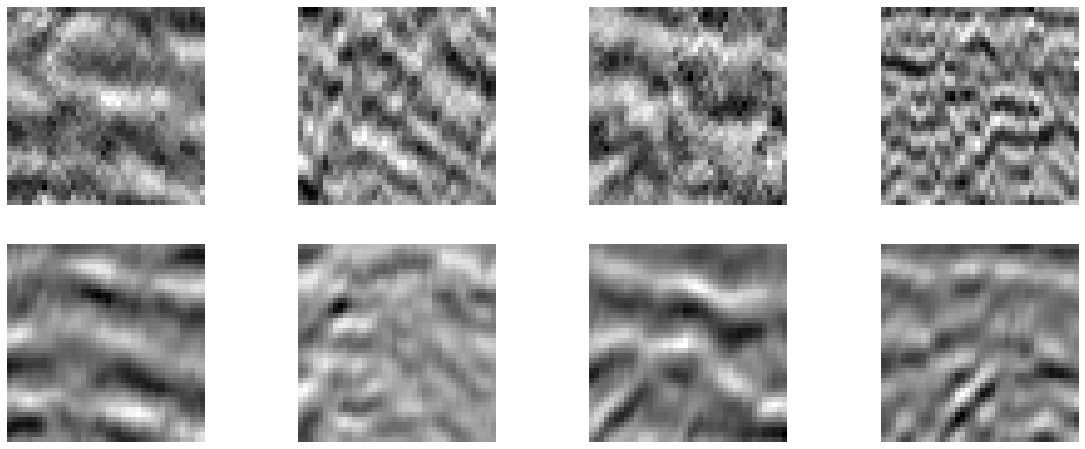

In [54]:
real_lae_predictions = lae.predict(COG_ptchs)
displayP(COG_ptchs, real_lae_predictions, name="2D_simple_lae.png")

In [55]:
COG_DN3 = ptch.unpatchify(real_lae_predictions.reshape(Ptchs_orig_shape), COG_crop.shape)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(COG_crop[:400, 1000:], cmap='gray', aspect="auto")
plt.title("Original noisy Data", fontsize=20)
plt.subplot(1,2,2)
plt.imshow(COG_DN3[:400,1000:], cmap='gray', aspect="auto")
plt.title("LSTM-AE Denoised Output", fontsize=20)
plt.savefig('Real_LSTM.png')